# Homecredit data capstone project

## Project plan

The context of this project is that, a startup is trying to provide risk evaluation services for banks. The goal is to use the Homecredit data to see what kind of models can be built for prediction, most importantly default risk prediction.

The plan for the project could be as follows:
- Perform exploratory data analysis;
- Build a default risk prediction model;
  1. Test baseline performance;
  2. Perform feature engineering and selection;
  3. Perform hyperparameter tuning;
  4. Iterate through steps 1-3 if needed;
  5. Evaluate on the test set;
- Perform cluster analysis;
  1. See if there is any high dimensional clusters of data by reducing dimensionality;
  2. Perform data clustering;
  3. Test default risk prediction model performance with cluster labels;
- Build an application outcome prediction model;
  1. Test baseline performance;
  2. Perform feature engineering and selection;
  3. Perform hyperparameter tuning;
  4. Iterate through steps 1-3 if needed;
  5. Evaluate on the test set;
  

## Data loading

In [ ]:
try:
  import duckdb
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  import featuretools as ft
  import re
  import xgboost as xgb
  import lightgbm as lgb
  from probatus.feature_elimination import ShapRFECV
  from skopt import BayesSearchCV
  from skopt.space import Real, Categorical, Integer
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import roc_auc_score
  from sklearn.dummy import DummyClassifier
  from sklearn.compose import ColumnTransformer
  from sklearn.pipeline import Pipeline
  from sklearn.impute import SimpleImputer
  from sklearn.preprocessing import OneHotEncoder, RobustScaler
  import joblib
  import shap
  import umap
  import hdbscan
  
except ImportError:
  !git clone --recursive https://github.com/Microsoft/LightGBM
  !cd LightGBM && rm -rf build && mkdir build && cd build \
  && cmake -DUSE_GPU=1 ../../LightGBM \
  && make -j4 && cd ../python-package \
  && python3 setup.py install --precompile --gpu;

  !pip install matplotlib==3.4.0
  !pip install xgboost==1.7.4
  !pip install shap
  !pip install duckdb
  !pip install probatus
  !pip install scikit-optimize
  !pip install featuretools
  !pip install hdbscan
  !pip install umap-learn

  import os
  os.kill(os.getpid(), 9)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Datasets/home-credit-default-risk.zip -d .
!cp /content/gdrive/MyDrive/DS_stuff/ds_utils.py .
!cp /content/gdrive/MyDrive/TuringCollege/TC_projects/m3_s4_project/homecredit_utils.py .

In [ ]:
from ds_utils import *
from homecredit_utils import *

In [ ]:
application_df = pd.read_csv('application_train.csv')

application_train_df, application_test_df = train_test_split(
    application_df, test_size=0.1, 
    stratify=application_df['TARGET'], 
    random_state=0)

In [ ]:
bureau_df = pd.read_csv('bureau.csv')
bureau_balance_df = pd.read_csv('bureau_balance.csv')
pos_cash_balance_df = pd.read_csv('POS_CASH_balance.csv')
credit_card_balance_df = pd.read_csv('credit_card_balance.csv')
previous_application_df = pd.read_csv('previous_application.csv')
installments_payments_df = pd.read_csv('installments_payments.csv')

### Dataframe info

**application_train dataset**

In [ ]:
application_df.info()
application_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


**bureau dataset**

In [ ]:
bureau_df.info()
bureau_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


**bureau_balance dataset**

In [ ]:
bureau_balance_df.info()
bureau_balance_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


**POS_CASH_balance dataset**

In [ ]:
pos_cash_balance_df.info()
pos_cash_balance_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


**credit_card_balance dataset**

In [ ]:
credit_card_balance_df.info()
credit_card_balance_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


**previous_application dataset**

In [ ]:
previous_application_df.info()
previous_application_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


**installments_payments dataset**

In [ ]:
installments_payments_df.info()
installments_payments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## EDA

**Gender**

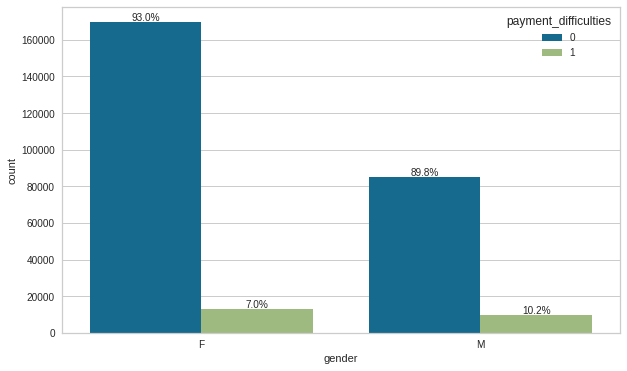

In [ ]:
df = duckdb.sql("""
SELECT CODE_GENDER gender, TARGET payment_difficulties
FROM application_train_df
WHERE gender='F' or gender='M'
""").df()

plt.figure(figsize=(10,6))

ax = sns.countplot(data=df, x='gender', hue='payment_difficulties', 
                   order=df['gender'].value_counts().index)

with_hue(ax, df['gender'], df['gender'].nunique(), 
         df['payment_difficulties'].nunique())

plt.show()

The percentage for payment difficulties is higher with males. We can check if it is statisticly significant, so the null hypothesis will be that the proportions are the same.

In [ ]:
default_df = pd.DataFrame(
    application_train_df[application_train_df['TARGET']==1]['CODE_GENDER']\
    .apply(lambda x: 1 if x=='M' else 0))

no_default_df = pd.DataFrame(
    application_train_df[application_train_df['TARGET']==0]['CODE_GENDER']\
    .apply(lambda x: 1 if x=='M' else 0))

perform_proportions_ztests(default_df, no_default_df, alpha=0.05)

------------------------------------------------------------------------------------------------------------------------------------------------------
Positive label group percentage: 43.01763494763226

Negative label group percentage: 33.166233998746755

Proportion test results of feature CODE_GENDER:

zstat: 21.4414, pvalue: 0.0000

P value is less than alpha 0.05, so we can reject the null hypothesis and suggest the alternative hypothesis is true
------------------------------------------------------------------------------------------------------------------------------------------------------




**Number of children**

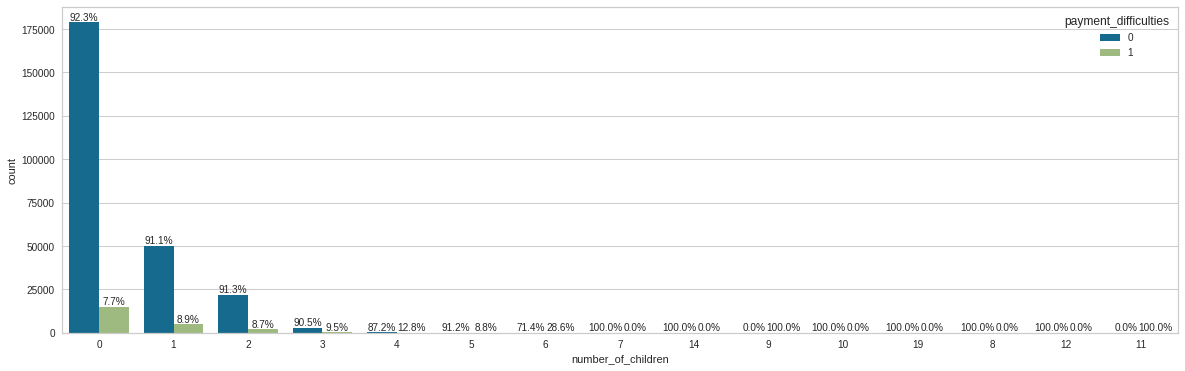

In [ ]:
df = duckdb.sql("""
SELECT CNT_CHILDREN number_of_children, TARGET payment_difficulties
FROM application_train_df
""").df()

plt.figure(figsize=(20,6))

ax = sns.countplot(data=df, x='number_of_children', hue='payment_difficulties',
                   order=df['number_of_children'].value_counts().index)

with_hue(ax, df['number_of_children'], df['number_of_children'].nunique(),
         df['payment_difficulties'].nunique())

plt.legend(loc='upper right', title='payment_difficulties')
plt.show()

Let's check if having children increases the risk of payment difficulty by doing a statistical test.

In [ ]:
default_df = pd.DataFrame(
    application_train_df[application_train_df['TARGET']==1]['CNT_CHILDREN']\
    .apply(lambda x: 1 if x>0 else 0))

no_default_df = pd.DataFrame(
    application_train_df[application_train_df['TARGET']==0]['CNT_CHILDREN']\
    .apply(lambda x: 1 if x>0 else 0))

perform_proportions_ztests(default_df, no_default_df, alpha=0.05)

------------------------------------------------------------------------------------------------------------------------------------------------------
Positive label group percentage: 33.049861247873956

Negative label group percentage: 29.24089159430669

Proportion test results of feature CNT_CHILDREN:

zstat: 8.6934, pvalue: 0.0000

P value is less than alpha 0.05, so we can reject the null hypothesis and suggest the alternative hypothesis is true
------------------------------------------------------------------------------------------------------------------------------------------------------




**Income**

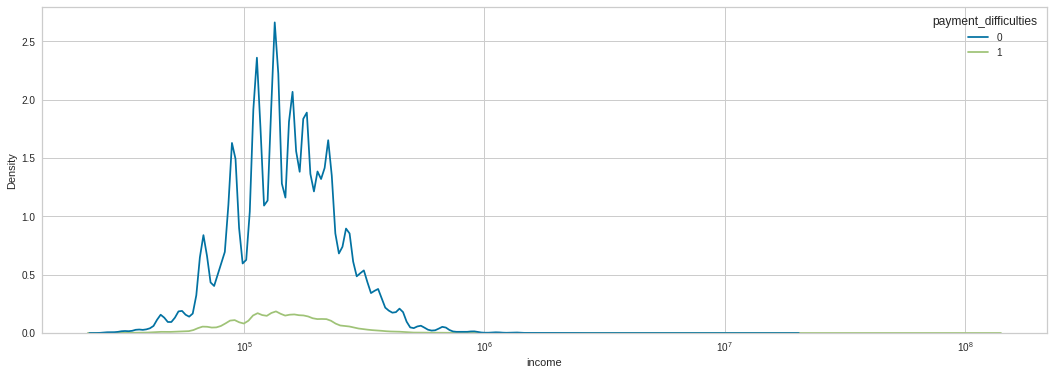

In [ ]:
df = duckdb.sql("""
SELECT AMT_INCOME_TOTAL income, TARGET payment_difficulties
FROM application_train_df
""").df()

plt.figure(figsize=(18,6))

ax = sns.kdeplot(data=df, x='income', hue='payment_difficulties', 
                 log_scale=True)

plt.show()

In [ ]:
default_df = pd.DataFrame(
    application_train_df[application_train_df['TARGET']==1]['AMT_INCOME_TOTAL'])

no_default_df = pd.DataFrame(
    application_train_df[application_train_df['TARGET']==0]['AMT_INCOME_TOTAL'])

compare_means(default_df, no_default_df, alpha=0.05, alternative='two-sided', 
              usevar='unequal', value=0)

------------------------------------------------------------------------------------------------------------------------------------------------------
Positive label group mean: 166281.41182526184

Negative label group mean: 168114.52554314744

Positive label group std: 786566.7115129095

Negative label group std: 96455.38965025189

Mean ztest results of feature AMT_INCOME_TOTAL:

zstat: -0.3458, pvalue: 0.7295

P value is more than alpha 0.05, so we fail to reject the null hypothesis
------------------------------------------------------------------------------------------------------------------------------------------------------




**Credit**

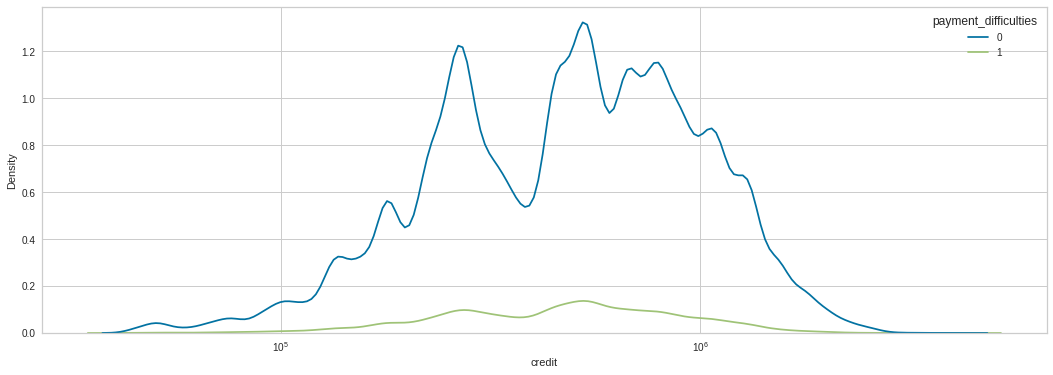

In [ ]:
df = duckdb.sql("""
SELECT AMT_CREDIT credit, TARGET payment_difficulties
FROM application_train_df
""").df()

plt.figure(figsize=(18,6))

ax = sns.kdeplot(data=df, x='credit', hue='payment_difficulties',
                 log_scale=True)

plt.show()

In [ ]:
default_df = pd.DataFrame(
    application_train_df[application_train_df['TARGET']==1]['AMT_CREDIT'])

no_default_df = pd.DataFrame(
    application_train_df[application_train_df['TARGET']==0]['AMT_CREDIT'])

compare_means(default_df, no_default_df, alpha=0.05, alternative='two-sided', 
              usevar='unequal', value=0)

------------------------------------------------------------------------------------------------------------------------------------------------------
Positive label group mean: 557677.7128278578

Negative label group mean: 599046.7783994271

Positive label group std: 345794.2762163154

Negative label group std: 404865.98707167606

Mean ztest results of feature AMT_CREDIT:

zstat: -11.6136, pvalue: 0.0000

P value is less than alpha 0.05, so we can reject the null hypothesis and suggest the alternative hypothesis is true
------------------------------------------------------------------------------------------------------------------------------------------------------




**Occupation type**

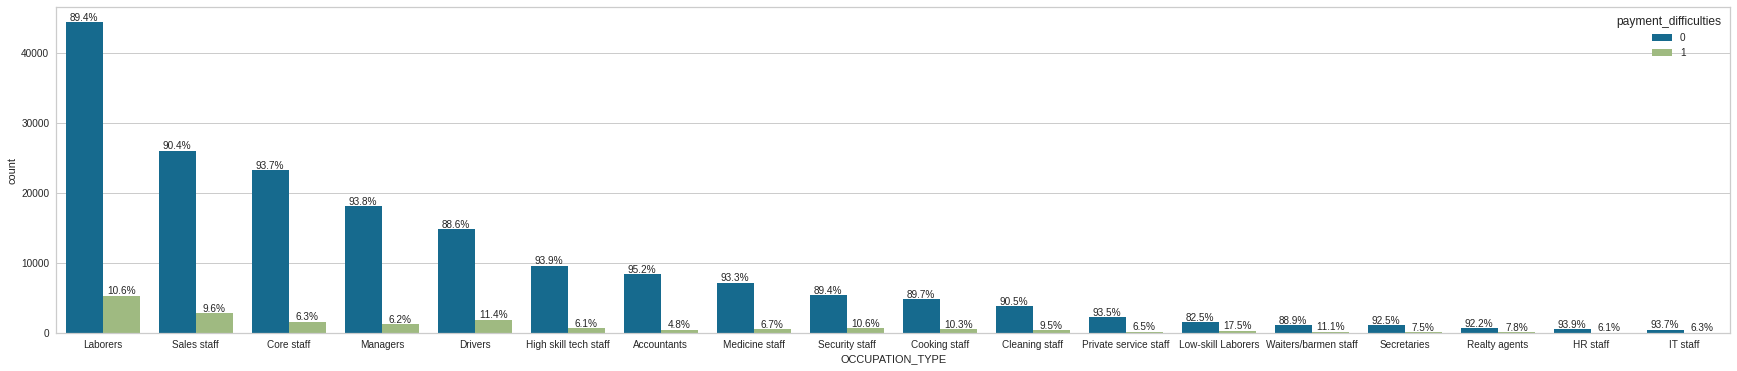

In [ ]:
df = duckdb.sql("""
SELECT OCCUPATION_TYPE, TARGET payment_difficulties
FROM application_train_df
""").df()

plt.figure(figsize=(30,6))

ax = sns.countplot(data=df, x='OCCUPATION_TYPE', hue='payment_difficulties',
                   order=df['OCCUPATION_TYPE'].value_counts().index)

with_hue(ax, df['OCCUPATION_TYPE'], df['OCCUPATION_TYPE'].nunique(),
         df['payment_difficulties'].nunique())

plt.show()

Observations:
- The most common occupation type is laborers.
- For low-skill laborers the percentage is the highest of 17,5%, but the count is rather low.

**Number of family members**

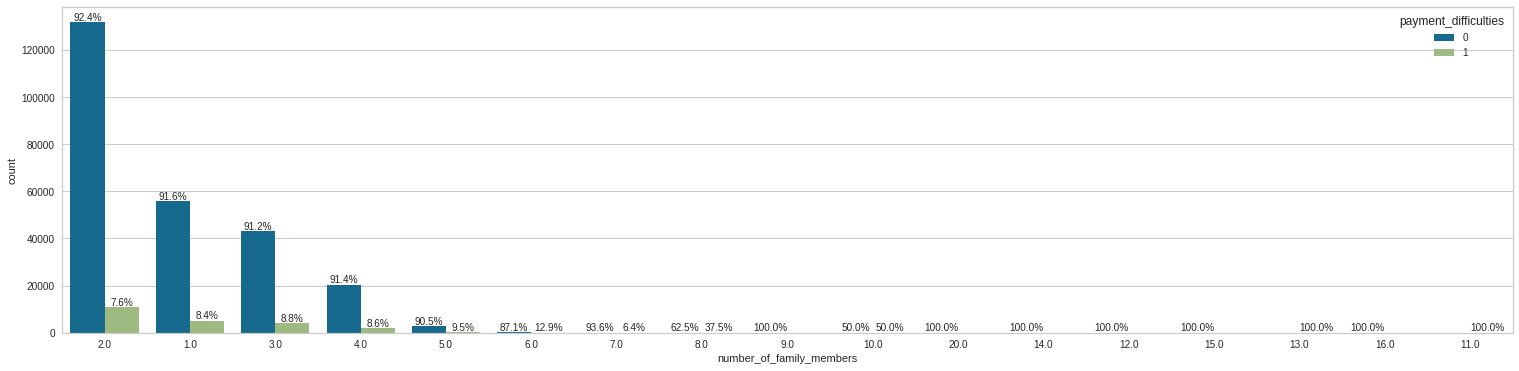

In [ ]:
df = duckdb.sql("""
SELECT CNT_FAM_MEMBERS number_of_family_members, TARGET payment_difficulties
FROM application_train_df
""").df()

plt.figure(figsize=(26,6))

ax = sns.countplot(data=df, x='number_of_family_members', 
                   hue='payment_difficulties', 
                   order=df['number_of_family_members'].value_counts().index)

with_hue(ax, df['number_of_family_members'], 
         df['number_of_family_members'].nunique(),
         df['payment_difficulties'].nunique())

plt.legend(loc='upper right', title='payment_difficulties')
plt.show()

Observations:
- The most common number of family members is 2.
- There doesn't seem to be much difference in payment difficulties.

**Organization type**

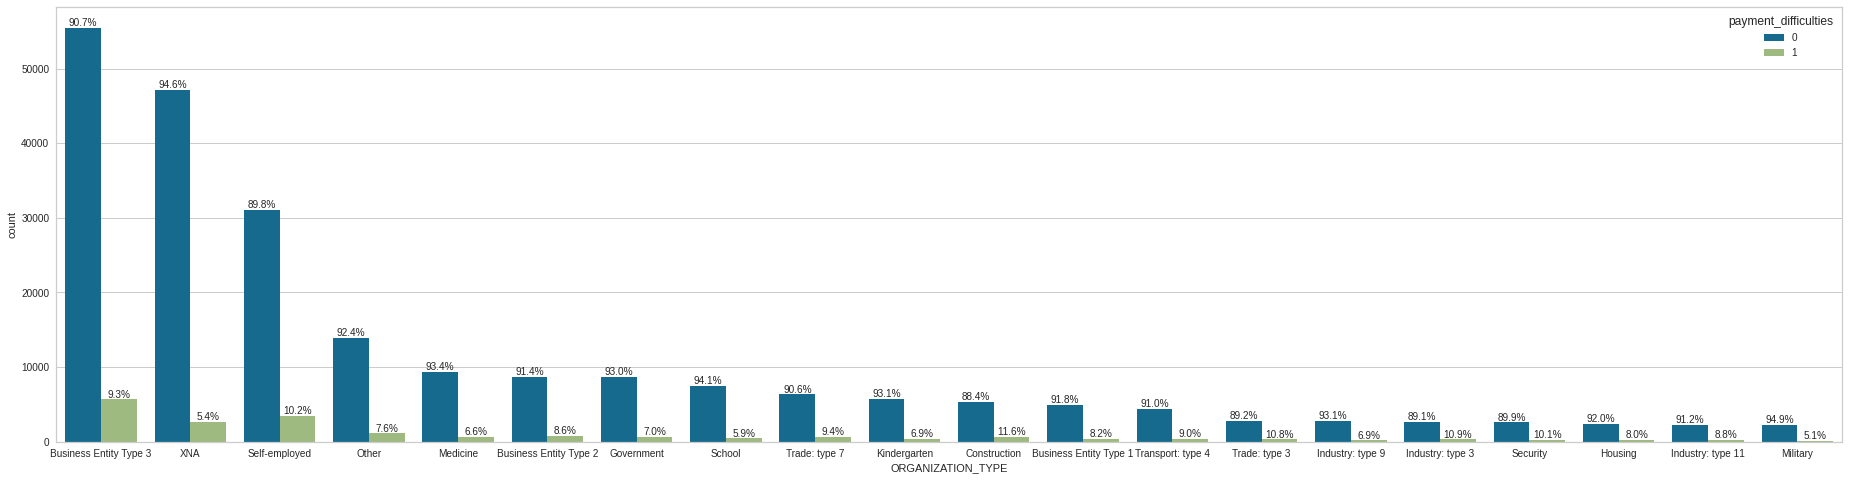

In [ ]:
df = duckdb.sql("""
SELECT ORGANIZATION_TYPE, TARGET payment_difficulties
FROM application_train_df
""").df()

plt.figure(figsize=(32,8))

order_idx = df['ORGANIZATION_TYPE'].value_counts().index[:20]
df = df[df['ORGANIZATION_TYPE'].isin(order_idx)]

ax = sns.countplot(data=df, x='ORGANIZATION_TYPE', hue='payment_difficulties',
                   order=order_idx)

with_hue(ax, df['ORGANIZATION_TYPE'], df['ORGANIZATION_TYPE'].nunique(),
         df['payment_difficulties'].nunique())

plt.legend(loc='upper right', title='payment_difficulties')
plt.show()

Observations:
- The most common organization type is business entity type 3.
- Seems like self-employed has a higher percentage in payment difficulties.

**Active credit**

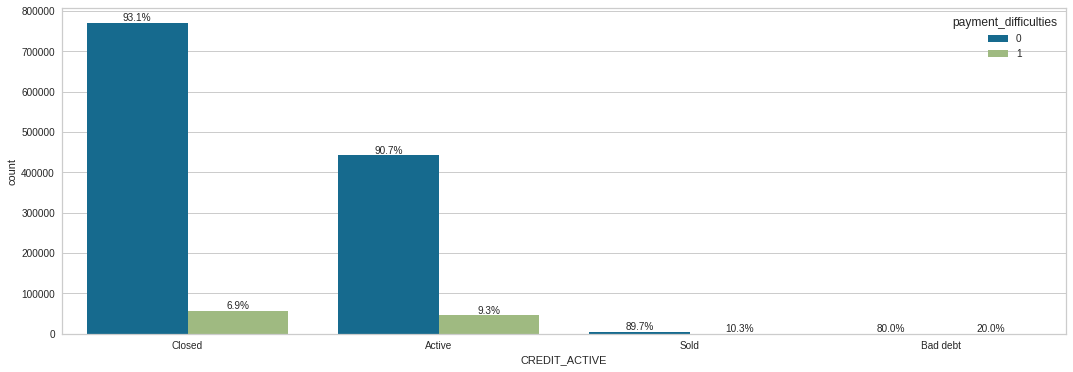

In [ ]:
df = duckdb.sql("""
SELECT b.CREDIT_ACTIVE, a.TARGET payment_difficulties
FROM application_train_df a
JOIN bureau_df b ON a.SK_ID_CURR=b.SK_ID_CURR
""").df()

plt.figure(figsize=(18,6))

ax = sns.countplot(data=df, x='CREDIT_ACTIVE', hue='payment_difficulties',
                   order=df['CREDIT_ACTIVE'].value_counts().index)

with_hue(ax, df['CREDIT_ACTIVE'], df['CREDIT_ACTIVE'].nunique(),
         df['payment_difficulties'].nunique())

plt.show()

Seems like people with active credit from other financial institutions have higher payment difficulty percentage.

**Credit type**

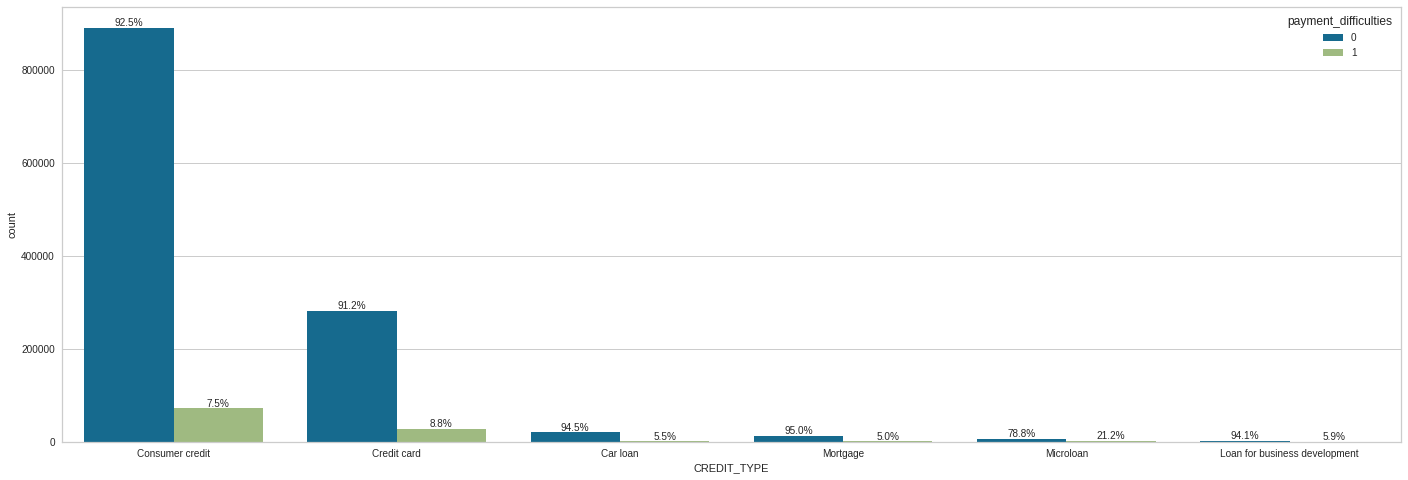

In [ ]:
df = duckdb.sql("""
SELECT b.CREDIT_TYPE, a.TARGET payment_difficulties
FROM application_train_df a
JOIN bureau_df b ON a.SK_ID_CURR=b.SK_ID_CURR
""").df()

plt.figure(figsize=(24,8))

order_idx = df['CREDIT_TYPE'].value_counts().index[:6]
df = df[df['CREDIT_TYPE'].isin(order_idx)]

ax = sns.countplot(data=df, x='CREDIT_TYPE', hue='payment_difficulties',
                   order=order_idx)

with_hue(ax, df['CREDIT_TYPE'], df['CREDIT_TYPE'].nunique(),
         df['payment_difficulties'].nunique())

plt.legend(loc='upper right', title='payment_difficulties')
plt.show()

Seems like people with credit card credit type from other financial institutions have higher payment difficulty percentage.

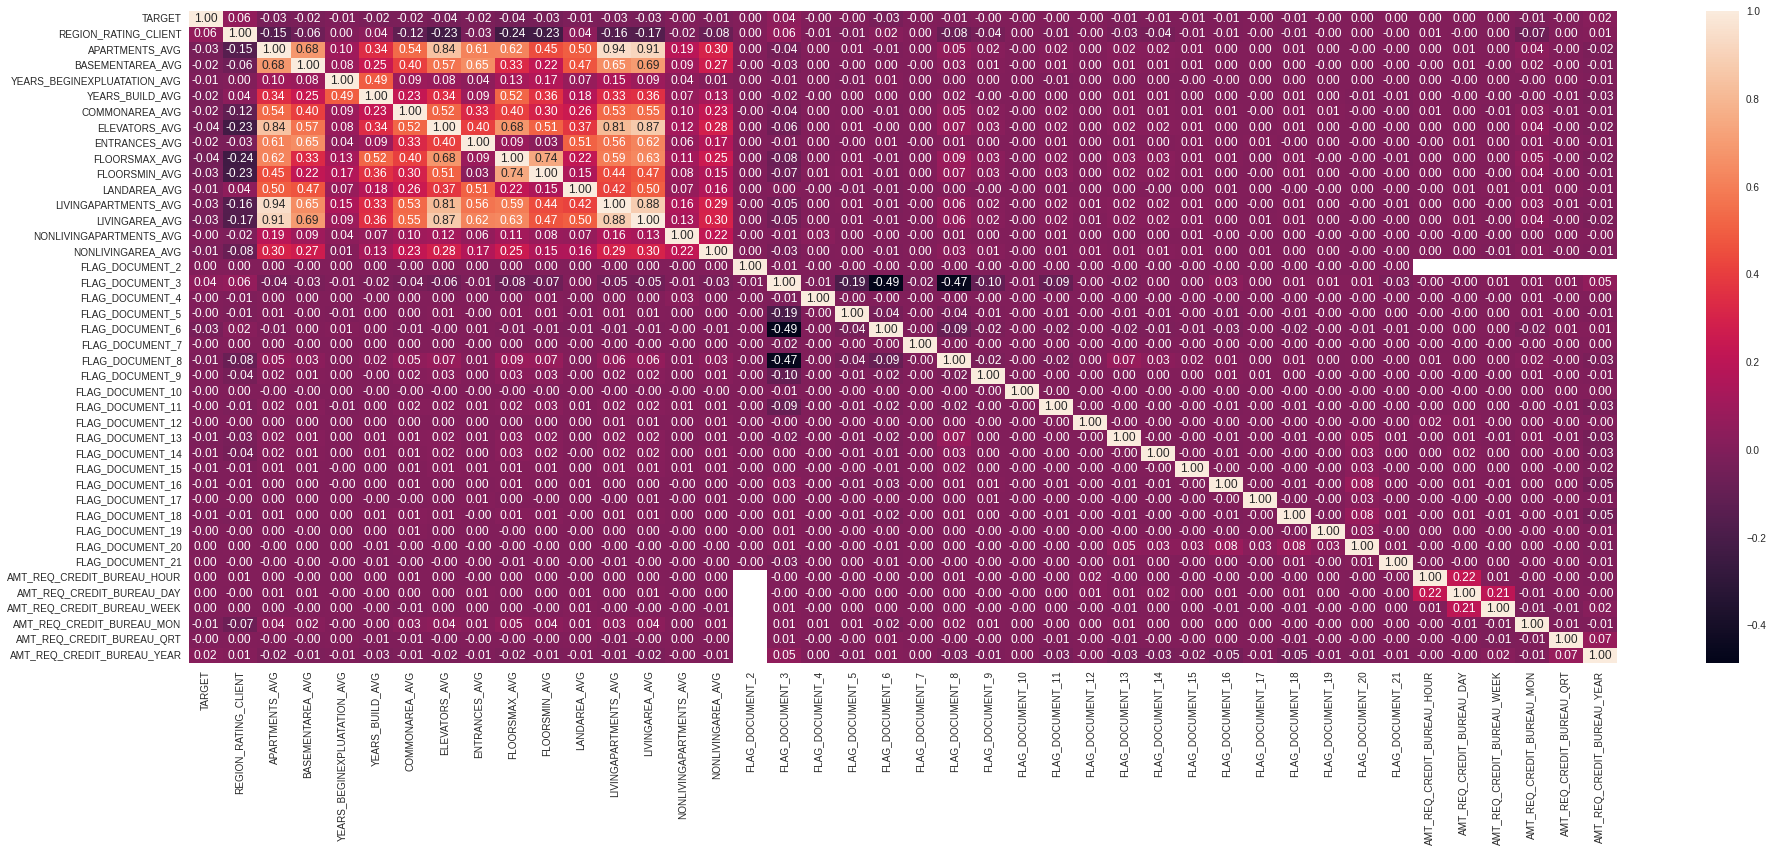

In [ ]:
corr = duckdb.sql("""
SELECT TARGET, REGION_RATING_CLIENT, APARTMENTS_AVG, BASEMENTAREA_AVG, 
YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, 
ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG,
LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, FLAG_DOCUMENT_2,
FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6,
FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10,
FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14,
FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18,
FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21,
AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, 
AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON,
AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR
FROM application_train_df
""").df().corr()

plt.figure(figsize=(32,12))

sns.heatmap(data=corr, annot=True, fmt='.2f')

plt.show()

There doesn't seem to be much correlation between the target variable and different document flags, information about the house a client lives in and other variables.

**Average credit drawings**

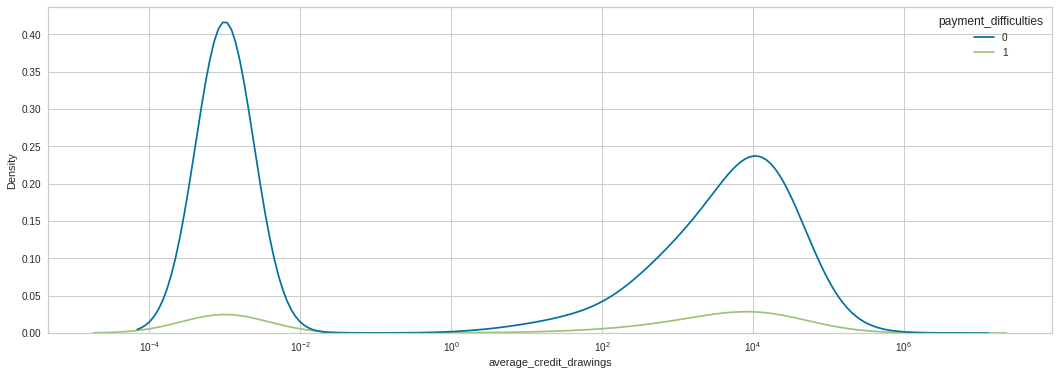

In [ ]:
df = duckdb.sql("""
SELECT AVG(ccb.AMT_DRAWINGS_POS_CURRENT+0.001) average_credit_drawings, 
a.TARGET payment_difficulties
FROM application_train_df a
JOIN credit_card_balance_df ccb ON a.SK_ID_CURR=ccb.SK_ID_CURR
GROUP BY a.SK_ID_CURR, 2
""").df()

plt.figure(figsize=(18,6))

ax = sns.kdeplot(data=df, x='average_credit_drawings', hue='payment_difficulties',
                 log_scale=True)

plt.show()

In [ ]:
default_df = pd.DataFrame(
    df[df['payment_difficulties']==1]['average_credit_drawings']).dropna()

no_default_df = pd.DataFrame(
    df[df['payment_difficulties']==0]['average_credit_drawings']).dropna()

compare_means(default_df, no_default_df, alpha=0.05, alternative='two-sided', 
              usevar='unequal', value=0)

------------------------------------------------------------------------------------------------------------------------------------------------------
Positive label group mean: 7981.546959670114

Negative label group mean: 8010.211362644682

Positive label group std: 16487.334394425365

Negative label group std: 23744.31967771587

Mean ztest results of feature average_credit_drawings:

zstat: -0.0737, pvalue: 0.9413

P value is more than alpha 0.05, so we fail to reject the null hypothesis
------------------------------------------------------------------------------------------------------------------------------------------------------




**Average number of credit drawings**

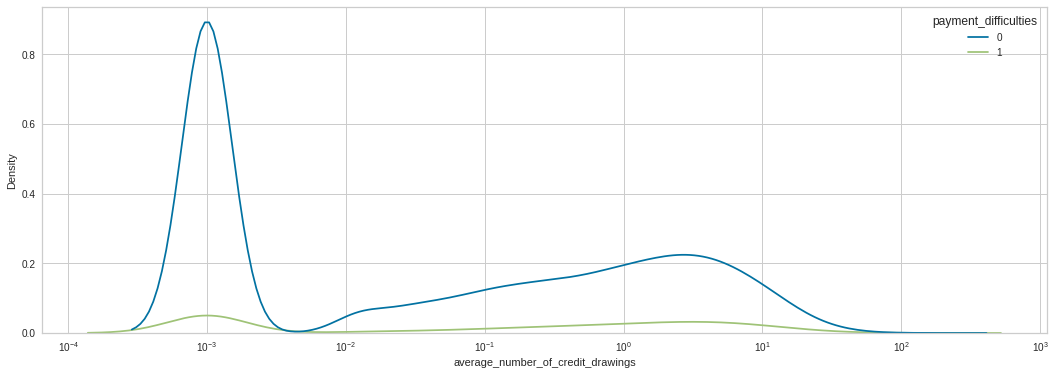

In [ ]:
df = duckdb.sql("""
SELECT AVG(ccb.CNT_DRAWINGS_POS_CURRENT+0.001) average_number_of_credit_drawings, 
a.TARGET payment_difficulties
FROM application_train_df a
JOIN credit_card_balance_df ccb ON a.SK_ID_CURR=ccb.SK_ID_CURR
GROUP BY a.SK_ID_CURR, 2
""").df()

plt.figure(figsize=(18,6))

ax = sns.kdeplot(data=df, x='average_number_of_credit_drawings',
                 hue='payment_difficulties', log_scale=True)

plt.show()

In [ ]:
default_df = pd.DataFrame(
    df[df['payment_difficulties']==1]['average_number_of_credit_drawings']).dropna()

no_default_df = pd.DataFrame(
    df[df['payment_difficulties']==0]['average_number_of_credit_drawings']).dropna()

compare_means(default_df, no_default_df, alpha=0.05, alternative='two-sided', 
              usevar='unequal', value=0)

------------------------------------------------------------------------------------------------------------------------------------------------------
Positive label group mean: 2.3594885466353146

Negative label group mean: 1.6553175568992067

Positive label group std: 4.811438410459071

Negative label group std: 3.9446460435482464

Mean ztest results of feature average_number_of_credit_drawings:

zstat: 8.4103, pvalue: 0.0000

P value is less than alpha 0.05, so we can reject the null hypothesis and suggest the alternative hypothesis is true
------------------------------------------------------------------------------------------------------------------------------------------------------




**Average credit amount**

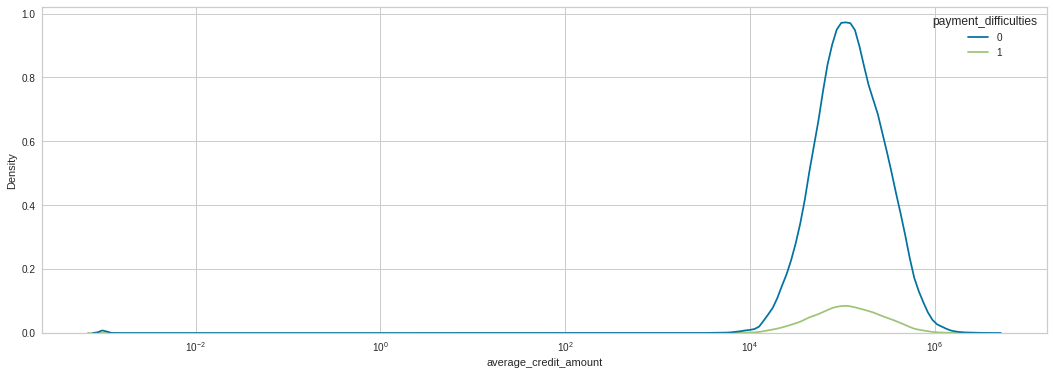

In [ ]:
df = duckdb.sql("""
SELECT AVG(pa.AMT_CREDIT+0.001) average_credit_amount, 
a.TARGET payment_difficulties
FROM application_train_df a
JOIN previous_application_df pa ON a.SK_ID_CURR=pa.SK_ID_CURR
GROUP BY a.SK_ID_CURR, 2
""").df()

plt.figure(figsize=(18,6))

ax = sns.kdeplot(data=df, x='average_credit_amount', hue='payment_difficulties',
                 log_scale=True)

plt.show()

In [ ]:
default_df = pd.DataFrame(
    df[df['payment_difficulties']==1]['average_credit_amount']).dropna()

no_default_df = pd.DataFrame(
    df[df['payment_difficulties']==0]['average_credit_amount']).dropna()

compare_means(default_df, no_default_df, alpha=0.05, alternative='two-sided', 
              usevar='unequal', value=0)

------------------------------------------------------------------------------------------------------------------------------------------------------
Positive label group mean: 161571.2096231851

Negative label group mean: 168717.6439657448

Positive label group std: 156982.9386256334

Negative label group std: 164716.2194610775

Mean ztest results of feature average_credit_amount:

zstat: -4.5996, pvalue: 0.0000

P value is less than alpha 0.05, so we can reject the null hypothesis and suggest the alternative hypothesis is true
------------------------------------------------------------------------------------------------------------------------------------------------------




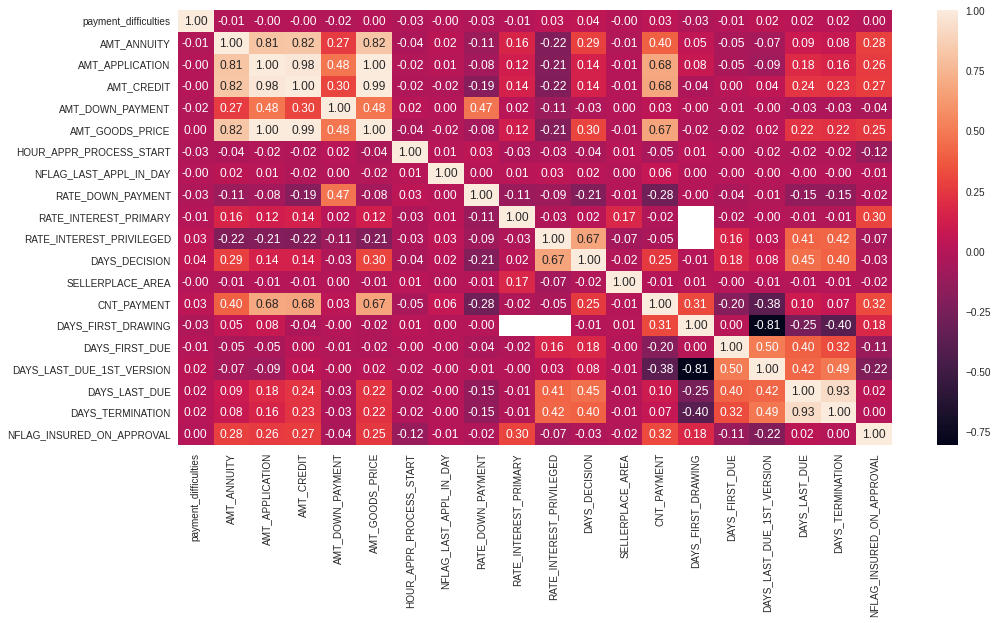

In [ ]:
corr = duckdb.sql("""
SELECT a.TARGET payment_difficulties, pa.*
FROM application_train_df a
JOIN previous_application_df pa ON a.SK_ID_CURR=pa.SK_ID_CURR
""").df().drop(columns=['SK_ID_PREV', 'SK_ID_CURR']).corr()

plt.figure(figsize=(16,8))

sns.heatmap(data=corr, annot=True, fmt='.2f')

plt.show()

We can see that there are variables that have perfect or near perfect correlations with each other, like AMT_GOODS_PRICE and AMT_APPLICATION. Also, there doesn't seem to be much correlation with the target variable.

## Default risk prediction

### Baseline performance

Cross validating on only application dataset without any other features from other tables.

In [ ]:
X_train = application_train_df.astype(
    {col:'category' \
     for col in application_train_df.select_dtypes('object').columns})

X_train.drop(columns=['TARGET', 'SK_ID_CURR'], inplace=True)

y_train = application_train_df['TARGET']

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=0, enable_categorical=True, 
                            tree_method='gpu_hist', class_weight='balanced')

lgbm_clf = lgb.LGBMClassifier(random_state=0, device_type='gpu',
                              class_weight='balanced')

In [ ]:
cross_validate_models(models={'XGBoost':xgb_clf, 'LGBM':lgbm_clf},
                      X_train=X_train,
                      y_train=y_train,
                      metrics=['roc_auc'],
                      cv_folds=5)

,model_name,mean_roc_auc,std_roc_auc
0,XGBoost,0.742,0.002
1,LGBM,0.754,0.002


### Feature engineering and selection

New features will be created by aggregating columns from other relational tables using deep feature synthesis from feature tools library. There will also be a set of difference and ratio features created from combinations of selected columns from the application table. After new feature generation, feature selection will be performed using probatus shap recursive feature elimination.

In [ ]:
report = feature_engineering_and_selection(
    application_train_df, bureau_df, bureau_balance_df, pos_cash_balance_df,
    credit_card_balance_df, previous_application_df, installments_payments_df
)

report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,2602,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR...",0.747
2,1822,[FLAG_EMP_PHONE__REGION_RATING_CLIENT_W_CITY_d...,0.748
3,1276,[FLAG_EMP_PHONE__REGION_RATING_CLIENT_W_CITY_d...,0.748
4,894,[SKEWprevious_applicationinstallments_payments...,0.747
5,626,[SKEWprevious_applicationinstallments_payments...,0.748
6,439,[REGION_POPULATION_RELATIVE__LIVE_CITY_NOT_WOR...,0.748
7,308,[AMT_GOODS_PRICE__REGION_POPULATION_RELATIVE_r...,0.749
8,216,"[COMMONAREA_AVG, STDinstallments_paymentsDAYS_...",0.748
9,152,"[STDinstallments_paymentsDAYS_ENTRY_PAYMENT, A...",0.748
10,107,"[STDinstallments_paymentsDAYS_ENTRY_PAYMENT, A...",0.748


Dataset with 308 features will be selected.

In [ ]:
final_train_ft_features_df = pd.read_csv('/content/gdrive/MyDrive/Datasets/final_train_ft_features.csv')

final_train_ft_features_df = preprocess_ds(final_train_ft_features_df)

X_train = final_train_ft_features_df.drop(columns='TARGET')

y_train = final_train_ft_features_df['TARGET']

In [ ]:
cross_validate_models(models={'XGBoost':xgb_clf, 'LGBM':lgbm_clf},
                      X_train=X_train,
                      y_train=y_train,
                      metrics=['roc_auc'],
                      cv_folds=5)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,model_name,mean_roc_auc,std_roc_auc
0,XGBoost,0.756,0.003
1,LGBM,0.773,0.001


### Hyperparameter tuning

In [ ]:
lgb_param_grid = {
    'n_estimators': Integer(50, 1000),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'num_leaves': Integer(20, 3000),
    'max_depth': Integer(3, 12),
    'min_data_in_leaf': Integer(200, 10000),
    'lambda_l1': Integer(0, 100),
    'lambda_l2': Integer(0, 100),
    'min_gain_to_split': Real(0.01, 15, prior='log-uniform'),
    'bagging_fraction': Real(0.2, 0.95, prior='log-uniform'),
    'bagging_freq': Integer(1, 2),
    'feature_fraction': Real(0.2, 0.95, prior='log-uniform')
}

bayes_search = BayesSearchCV(
    lgbm_clf, lgb_param_grid, n_iter=50, cv=3, scoring='roc_auc')

search_res = bayes_search.fit(X_train, y_train)

In [ ]:
search_res.best_score_

0.7771206482442694

In [ ]:
search_res.best_params_

OrderedDict([('bagging_fraction', 0.9499999999999998),
             ('bagging_freq', 1),
             ('feature_fraction', 0.20000000000000004),
             ('lambda_l1', 100),
             ('lambda_l2', 54),
             ('learning_rate', 0.027692076840655697),
             ('max_depth', 10),
             ('min_data_in_leaf', 214),
             ('min_gain_to_split', 0.023965005814721285),
             ('n_estimators', 1000),
             ('num_leaves', 20)])

In [ ]:
lgbm_clf = lgb.LGBMClassifier(random_state=0, device_type='gpu', 
                              class_weight='balanced', bagging_fraction=0.95,
                              bagging_freq=1, feature_fraction=0.2,
                              lambda_l1=100, lambda_l2=54, learning_rate=0.0277, 
                              max_depth=10, min_data_in_leaf=214, 
                              min_gain_to_split=0.024, n_estimators=1000, 
                              num_leaves=20)

In [ ]:
cross_validate_models(models={'LGBM':lgbm_clf},
                      X_train=X_train,
                      y_train=y_train,
                      metrics=['roc_auc'],
                      cv_folds=5)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,model_name,mean_roc_auc,std_roc_auc
0,LGBM,0.778,0.001


### Evaluating on the test set

In [ ]:
final_test_ft_features_df = pd.read_csv('/content/gdrive/MyDrive/Datasets/final_test_ft_features.csv')

final_test_ft_features_df = preprocess_ds(final_test_ft_features_df)

X_test = final_test_ft_features_df.drop(columns='TARGET')

y_test = final_test_ft_features_df['TARGET']

In [ ]:
lgbm_clf.fit(X_train, y_train)

y_pred = lgbm_clf.predict_proba(X_test)

y_pred = np.array([x[1] for x in y_pred])

roc_auc = roc_auc_score(y_test, y_pred)

fitted_models = {'Dummy':DummyClassifier(strategy='most_frequent'),
                 'LGBM':lgbm_clf}

In [ ]:
print(f'ROC AUC: {round(roc_auc, 3)}')

ROC AUC: 0.794


micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging


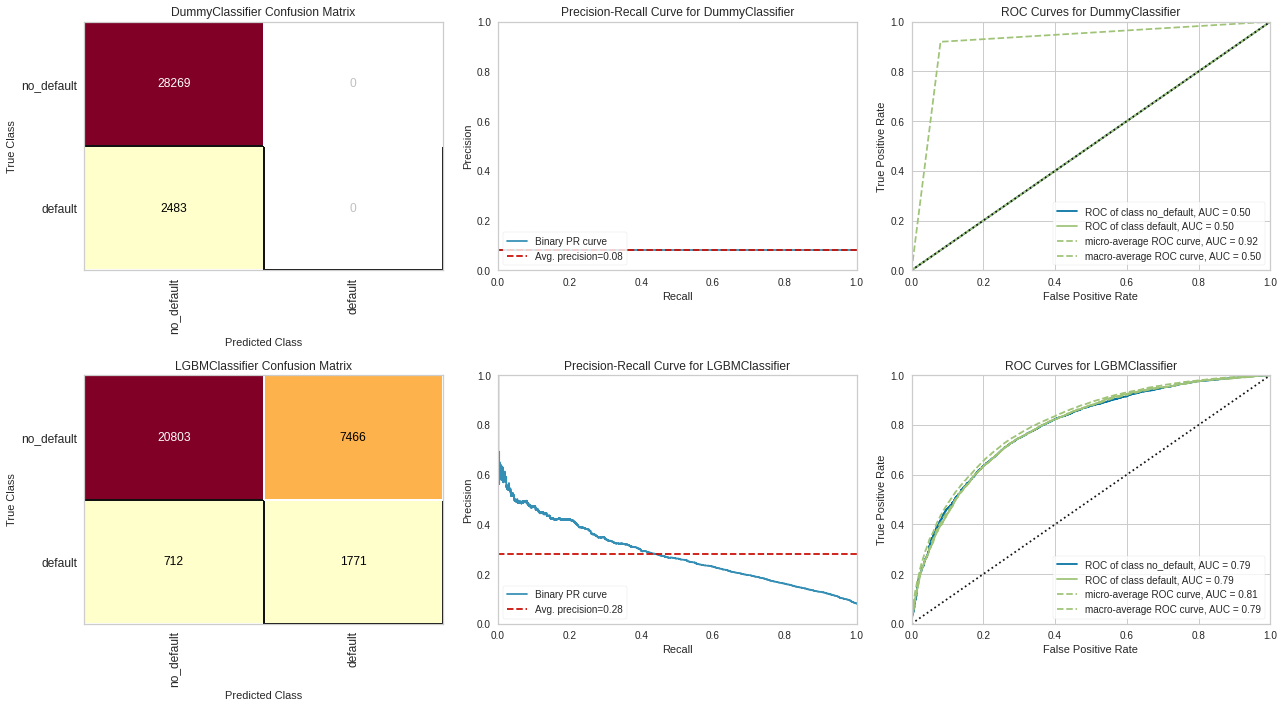

In [ ]:
plot_cm_pr_roc_curves_yb(
    models=fitted_models,
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test,
    plot_size=(18, 10),
    class_labels=['no_default','default'],
    plot_threshold=False
)

We can see that the model classifies a large portion of no_default as default, but this problem could be reduced by increasing the threshold for the probability of default. 

In [ ]:
_ = joblib.dump(lgbm_clf, "default_risk_lgbm.pkl")

In [ ]:
explainer = shap.TreeExplainer(lgbm_clf)

shap_values = explainer.shap_values(X_test)

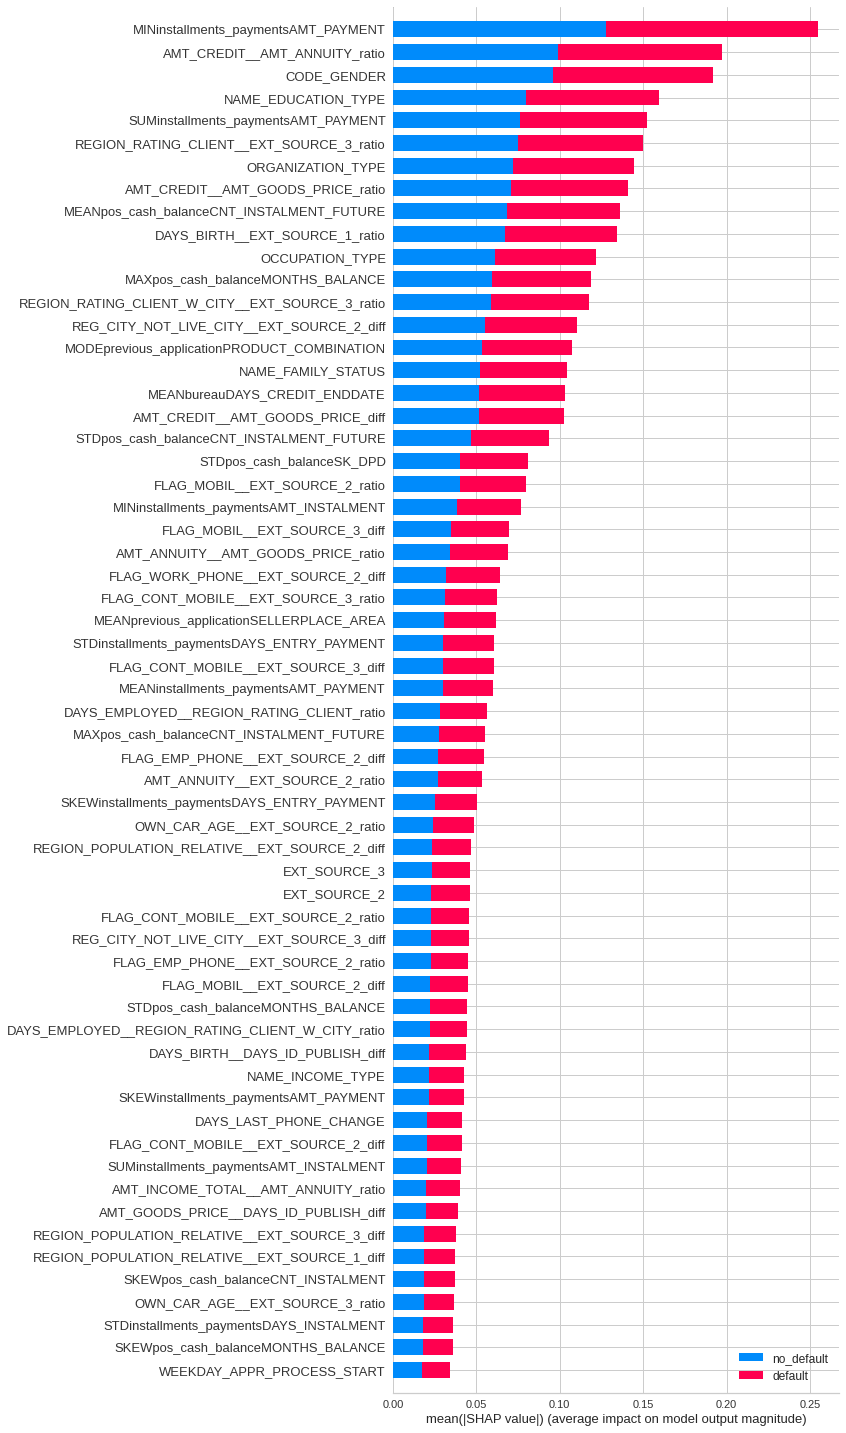

In [ ]:
shap.summary_plot(shap_values, X_test, class_names=['no_default','default'], 
                  max_display=60)

Looking at the top most important features MINinstallments_paymentsAMT_PAYMENT seems to be the most influencial. Second most important is AMT_CREDIT and AMT_ANNUITY ratio. Also, the CODE_GENDER is also quite important, but it may not be ethical to depend heavily on person's gender for making default risk predictions or maybe in some cases it shouldn't be used.

## Cluster analysis

### UMAP dimensionality reduction

In [ ]:
num_features = X_train.select_dtypes('number').columns

cat_features = X_train.select_dtypes('category').columns

num_transformer = Pipeline(
    steps=[
        ("scaler", RobustScaler()),
        ("imputer", SimpleImputer(strategy='median', add_indicator=True))
    ]
)

cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent", add_indicator=True)),
        ("oh_encoder", OneHotEncoder(drop='if_binary', handle_unknown="ignore"))
    ]
)

col_transformer = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ]
)

In [ ]:
train_sample = final_train_ft_features_df.sample(frac=0.1)

X_train = train_sample.drop(columns='TARGET')

y_train = train_sample['TARGET']

In [ ]:
umap_dr = Pipeline(steps=[('preprocessor', col_transformer),
                          ('dim_red', umap.UMAP(n_neighbors=20))])

X_reduced_umap = umap_dr.fit_transform(X_train)

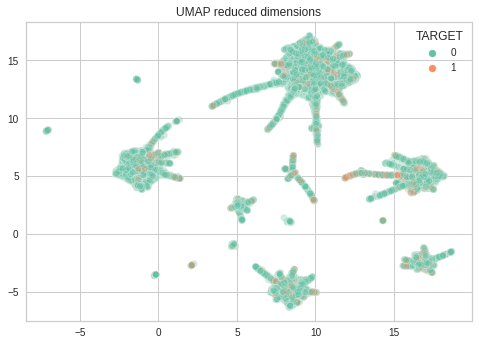

In [ ]:
ax = sns.scatterplot(x=X_reduced_umap[:,0], y=X_reduced_umap[:,1], hue=y_train,
                     alpha=0.3, palette='Set2')

ax.set_title('UMAP reduced dimensions')

plt.show()

### Clustering

In [ ]:
from sklearn.cluster import DBSCAN

clusterer = Pipeline(steps=[('preprocessor', col_transformer),
                            ('clusterer', DBSCAN(eps=30, min_samples=200))])

cluster_labels = clusterer.fit_predict(X_train)
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5])

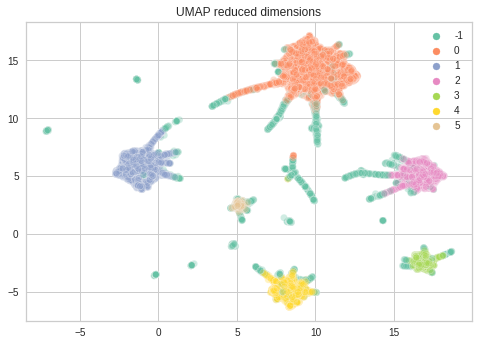

In [ ]:
ax = sns.scatterplot(x=X_reduced_umap[:,0], y=X_reduced_umap[:,1],
                     hue=cluster_labels, alpha=0.3, palette='Set2')

ax.set_title('UMAP reduced dimensions')

plt.show()

In [ ]:
clusterer = Pipeline(steps=[('preprocessor', col_transformer),
                            ('clusterer', hdbscan.HDBSCAN(min_cluster_size=250, 
                                                          core_dist_n_jobs=8, 
                                                          prediction_data=True))])

cluster_labels = clusterer.fit_predict(X_train)
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
_ = joblib.dump(clusterer, "hdbscan_clusterer.pkl")

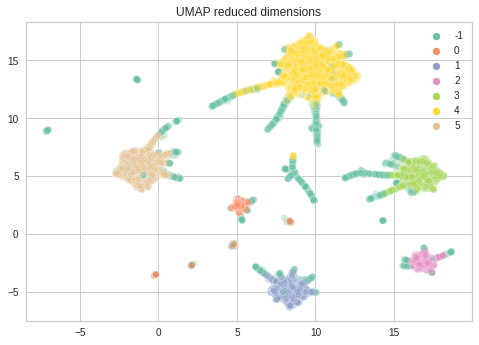

In [ ]:
ax = sns.scatterplot(x=X_reduced_umap[:,0], y=X_reduced_umap[:,1], 
                     hue=cluster_labels, alpha=0.3, palette='Set2')

ax.set_title('UMAP reduced dimensions')

plt.show()

As we can see there are clusters in high dimensional data. 6 clusters can be visible which are also labeled by cluster labels. Data points that are labeled as -1 represent outliers.

### Testing model performance with cluster labels

In [ ]:
clusterer = joblib.load('/content/gdrive/MyDrive/TuringCollege/TC_projects/m3_s4_project/api_code/hdbscan_clusterer.pkl')

In [ ]:
cluster_labels = hdbscan.approximate_predict(
    clusterer['clusterer'], clusterer['preprocessor'].transform(X_train))

X_train['cluster'] = cluster_labels[0]

Found unknown categories in columns [0, 6, 8] during transform. These unknown categories will be encoded as all zeros


In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=0, enable_categorical=True, 
                            tree_method='gpu_hist', class_weight='balanced')

lgbm_clf = lgb.LGBMClassifier(random_state=0, device_type='gpu',
                              class_weight='balanced')

In [ ]:
cross_validate_models(models={'XGBoost':xgb_clf, 'LGBM':lgbm_clf},
                      X_train=X_train,
                      y_train=y_train,
                      metrics=['roc_auc'],
                      cv_folds=5)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,model_name,mean_roc_auc,std_roc_auc
0,XGBoost,0.757,0.002
1,LGBM,0.773,0.002


ROC AUC is basicly the same so there is no benefit in using the cluster labels as a feature. Possible usage case could be to group clients into clusters and recommend services according to that cluster.

### Cluster comparison

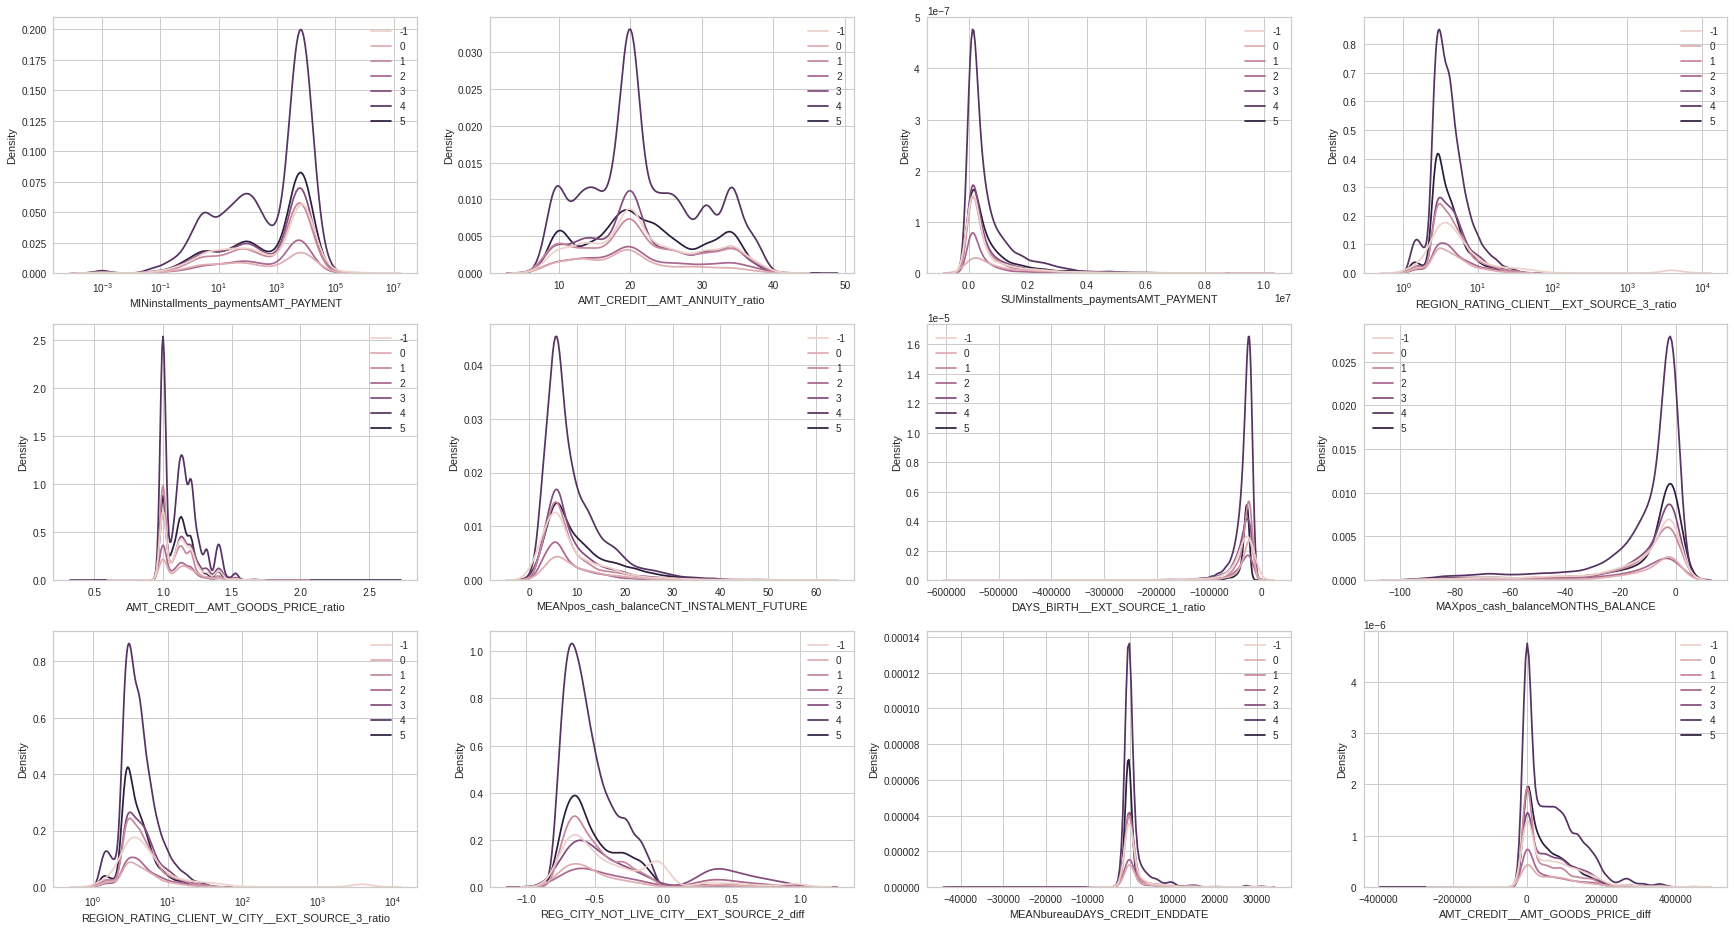

In [ ]:
rows, cols = 3, 4

fig, ax = plt.subplots(rows, cols, figsize=(30,16))

num_cols = [
    'MINinstallments_paymentsAMT_PAYMENT', 'AMT_CREDIT__AMT_ANNUITY_ratio',
    'SUMinstallments_paymentsAMT_PAYMENT', 'REGION_RATING_CLIENT__EXT_SOURCE_3_ratio',
    'AMT_CREDIT__AMT_GOODS_PRICE_ratio', 'MEANpos_cash_balanceCNT_INSTALMENT_FUTURE',
    'DAYS_BIRTH__EXT_SOURCE_1_ratio', 'MAXpos_cash_balanceMONTHS_BALANCE',
    'REGION_RATING_CLIENT_W_CITY__EXT_SOURCE_3_ratio',
    'REG_CITY_NOT_LIVE_CITY__EXT_SOURCE_2_diff',
    'MEANbureauDAYS_CREDIT_ENDDATE', 'AMT_CREDIT__AMT_GOODS_PRICE_diff'
]

cols_to_log = ['MINinstallments_paymentsAMT_PAYMENT', 
               'REGION_RATING_CLIENT__EXT_SOURCE_3_ratio', 
               'REGION_RATING_CLIENT_W_CITY__EXT_SOURCE_3_ratio']

i, j = 0, 0

for idx, col in enumerate(num_cols):
  if idx%cols==0 and idx>0 and i<rows and j<cols:
    j = 0
    i += 1
  elif idx>0:
    j += 1

  if col in cols_to_log:
    sns.kdeplot(x=X_train[col]+0.001, hue=cluster_labels, log_scale=True,
                ax=ax[i][j])
  else:
    sns.kdeplot(x=X_train[col], hue=cluster_labels, ax=ax[i][j])

plt.show()

We can see that there isn't much obvious difference in terms of clusters if we look at individual features.

## Application outcome prediction

### Baseline performance

Testing model performance before feature engineering.

In [ ]:
df = previous_application_df[
    previous_application_df['NAME_CONTRACT_STATUS']\
    .isin(['Approved', 'Refused'])]

df['NAME_CONTRACT_STATUS'] = df['NAME_CONTRACT_STATUS'].apply(
    lambda x: 1 if x=='Approved' else 0)

# Dropping columns that cause target leakage
df.drop(columns=['SK_ID_PREV', 'AMT_CREDIT', 'DAYS_DECISION',
                 'CODE_REJECT_REASON', 'NFLAG_INSURED_ON_APPROVAL', 
                 'CNT_PAYMENT', 'NAME_PORTFOLIO', 'AMT_ANNUITY',
                 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
                 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
                 'DAYS_TERMINATION'],
                 inplace=True)

# Splitting data in terms of client IDs, because 
# there are multiple data points for each client
train_idx, test_idx = train_test_split(df['SK_ID_CURR'].unique(), test_size=0.1, 
                                       random_state=0)

train_df = df[df['SK_ID_CURR'].isin(train_idx)]
test_df = df[df['SK_ID_CURR'].isin(test_idx)]

In [ ]:
train_df = preprocess_ds(train_df)

X_train = train_df.drop(columns=['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])

y_train = train_df['NAME_CONTRACT_STATUS']

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=0, enable_categorical=True, 
                            tree_method='gpu_hist', class_weight='balanced')

lgbm_clf = lgb.LGBMClassifier(random_state=0, device_type='gpu',
                              class_weight='balanced')

In [ ]:
cross_validate_models(models={'LGBM':lgbm_clf, 'XGBoost':xgb_clf},
                      X_train=X_train,
                      y_train=y_train,
                      metrics=['roc_auc'],
                      cv_folds=5)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


,model_name,mean_roc_auc,std_roc_auc
0,LGBM,0.851,0.001
1,XGBoost,0.855,0.000


### Feature engineering and selection

Ratio and difference features are created. After that, feature elimination is performed using probatus ShapRFECV.

In [ ]:
train_sample_df = train_df.sample(frac=0.1)

X_train = train_sample_df.drop(columns=['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])

X_train = create_diffs_ratios(X_train, X_train.select_dtypes('number').columns)

y_train = train_sample_df['NAME_CONTRACT_STATUS']

In [ ]:
lgbm_clf = lgb.LGBMClassifier(random_state=0, device_type='gpu',
                              class_weight='balanced')

lgb_param_grid = {'n_estimators': Integer(50, 1000),
                  'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                  'num_leaves': Integer(20, 3000),'max_depth': Integer(3, 12),
                  'min_data_in_leaf': Integer(200, 10000),
                  'lambda_l1': Integer(0, 100), 'lambda_l2': Integer(0, 100),
                  'min_gain_to_split': Real(0.01, 15, prior='log-uniform'),
                  'bagging_fraction': Real(0.2, 0.95, prior='log-uniform'),
                  'bagging_freq': Integer(1, 2),
                  'feature_fraction': Real(0.2, 0.95, prior='log-uniform')}

bayes_search = BayesSearchCV(lgbm_clf, lgb_param_grid, n_iter=10, cv=3, 
                             scoring='roc_auc')

shap_elimination = ShapRFECV(clf=bayes_search, step=0.1, cv=3, random_state=0,
                             scoring='roc_auc', n_jobs=-1)

report = shap_elimination.fit_compute(X_train, y_train, 
                                      check_additivity=False)

In [ ]:
report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,94,"[NAME_CONTRACT_TYPE, AMT_APPLICATION, AMT_DOWN...",0.838
2,85,"[AMT_DOWN_PAYMENT__RATE_DOWN_PAYMENT_diff, RAT...",0.837
3,77,"[AMT_DOWN_PAYMENT__RATE_DOWN_PAYMENT_diff, NFL...",0.838
4,70,"[AMT_DOWN_PAYMENT__RATE_DOWN_PAYMENT_diff, NFL...",0.838
5,63,"[AMT_DOWN_PAYMENT__RATE_DOWN_PAYMENT_diff, NFL...",0.837
6,57,"[AMT_APPLICATION__AMT_DOWN_PAYMENT_ratio, AMT_...",0.838
7,52,"[AMT_APPLICATION__AMT_DOWN_PAYMENT_ratio, AMT_...",0.837
8,47,"[AMT_APPLICATION__AMT_DOWN_PAYMENT_ratio, AMT_...",0.838
9,43,"[AMT_APPLICATION__AMT_DOWN_PAYMENT_ratio, AMT_...",0.837
10,39,"[AMT_APPLICATION__AMT_DOWN_PAYMENT_ratio, AMT_...",0.839


In [ ]:
selected_features = report['features_set'].loc[10]
selected_features

['AMT_APPLICATION__AMT_DOWN_PAYMENT_ratio',
 'AMT_APPLICATION__HOUR_APPR_PROCESS_START_ratio',
 'NAME_PAYMENT_TYPE',
 'AMT_APPLICATION__SELLERPLACE_AREA_ratio',
 'AMT_APPLICATION__SELLERPLACE_AREA_diff',
 'AMT_GOODS_PRICE__HOUR_APPR_PROCESS_START_ratio',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START__NFLAG_LAST_APPL_IN_DAY_ratio',
 'RATE_DOWN_PAYMENT',
 'AMT_GOODS_PRICE__SELLERPLACE_AREA_diff',
 'RATE_DOWN_PAYMENT__SELLERPLACE_AREA_ratio',
 'CHANNEL_TYPE',
 'HOUR_APPR_PROCESS_START__SELLERPLACE_AREA_ratio',
 'AMT_APPLICATION__RATE_DOWN_PAYMENT_diff',
 'AMT_GOODS_PRICE__HOUR_APPR_PROCESS_START_diff',
 'NAME_CLIENT_TYPE',
 'NAME_PRODUCT_TYPE',
 'NAME_GOODS_CATEGORY',
 'HOUR_APPR_PROCESS_START__RATE_DOWN_PAYMENT_diff',
 'NAME_CONTRACT_TYPE',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'AMT_GOODS_PRICE__RATE_DOWN_PAYMENT_diff',
 'NFLAG_LAST_APPL_IN_DAY__RATE_DOWN_PAYMENT_diff',
 'NAME_YIELD_GROUP',
 'RATE_DOWN_PAYMENT__SELLERPLACE_AREA_diff',
 'AMT_APPLICATION__AMT_DOWN_PAYMENT_diff',
 'AM

In [ ]:
X_train = train_df.drop(columns=['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])

X_train = create_diffs_ratios(X_train, X_train.select_dtypes('number').columns)

X_train = X_train[selected_features]

y_train = train_df['NAME_CONTRACT_STATUS']

In [ ]:
cross_validate_models(models={'LGBM':lgbm_clf, 'XGBoost':xgb_clf},
                      X_train=X_train,
                      y_train=y_train,
                      metrics=['roc_auc'],
                      cv_folds=5)

,model_name,mean_roc_auc,std_roc_auc
0,LGBM,0.851,0.000
1,XGBoost,0.855,0.001


No improvements were observed so original features will be used further on.

### Hyperparameter tuning

In [ ]:
X_train = train_df.drop(columns=['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])

y_train = train_df['NAME_CONTRACT_STATUS']

In [ ]:
lgbm_clf = lgb.LGBMClassifier(random_state=0, device_type='gpu',
                              class_weight='balanced')

lgb_param_grid = {'n_estimators': Integer(50, 1000),
                  'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                  'num_leaves': Integer(20, 3000),'max_depth': Integer(3, 12),
                  'min_data_in_leaf': Integer(200, 10000),
                  'lambda_l1': Integer(0, 100), 'lambda_l2': Integer(0, 100),
                  'min_gain_to_split': Real(0.01, 15, prior='log-uniform'),
                  'bagging_fraction': Real(0.2, 0.95, prior='log-uniform'),
                  'bagging_freq': Integer(1, 2),
                  'feature_fraction': Real(0.2, 0.95, prior='log-uniform')}

bayes_search = BayesSearchCV(lgbm_clf, lgb_param_grid, n_iter=40, cv=3, 
                             scoring='roc_auc')

search_res = bayes_search.fit(X_train, y_train)

In [ ]:
search_res.best_score_

0.8582315505382772

In [ ]:
search_res.best_params_

OrderedDict([('bagging_fraction', 0.9499999999999998),
             ('bagging_freq', 2),
             ('feature_fraction', 0.9499999999999998),
             ('lambda_l1', 0),
             ('lambda_l2', 0),
             ('learning_rate', 0.29999999999999993),
             ('max_depth', 12),
             ('min_data_in_leaf', 200),
             ('min_gain_to_split', 0.1323585703655359),
             ('n_estimators', 583),
             ('num_leaves', 3000)])

### Evaluating on the test set

In [ ]:
test_df = preprocess_ds(test_df)

X_test = test_df.drop(columns=['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])

y_test = test_df['NAME_CONTRACT_STATUS']

In [ ]:
lgbm_clf = lgb.LGBMClassifier(random_state=0, device_type='gpu', 
                              class_weight='balanced', bagging_fraction=0.95,
                              bagging_freq=2, feature_fraction=0.95,
                              lambda_l1=0, lambda_l2=0, learning_rate=0.3, 
                              max_depth=12, min_data_in_leaf=200, 
                              min_gain_to_split=0.132, n_estimators=583, 
                              num_leaves=3000)

In [ ]:
lgbm_clf.fit(X_train, y_train)

y_pred = lgbm_clf.predict_proba(X_test)

y_pred = np.array([x[1] for x in y_pred])

roc_auc = roc_auc_score(y_test, y_pred)

fitted_models = {'Dummy':DummyClassifier(strategy='most_frequent'),
                 'LGBM':lgbm_clf}

In [ ]:
print(f'ROC AUC: {round(roc_auc, 3)}')

ROC AUC: 0.848


micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.132
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_gain_to_split is set=0.132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.132
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ign

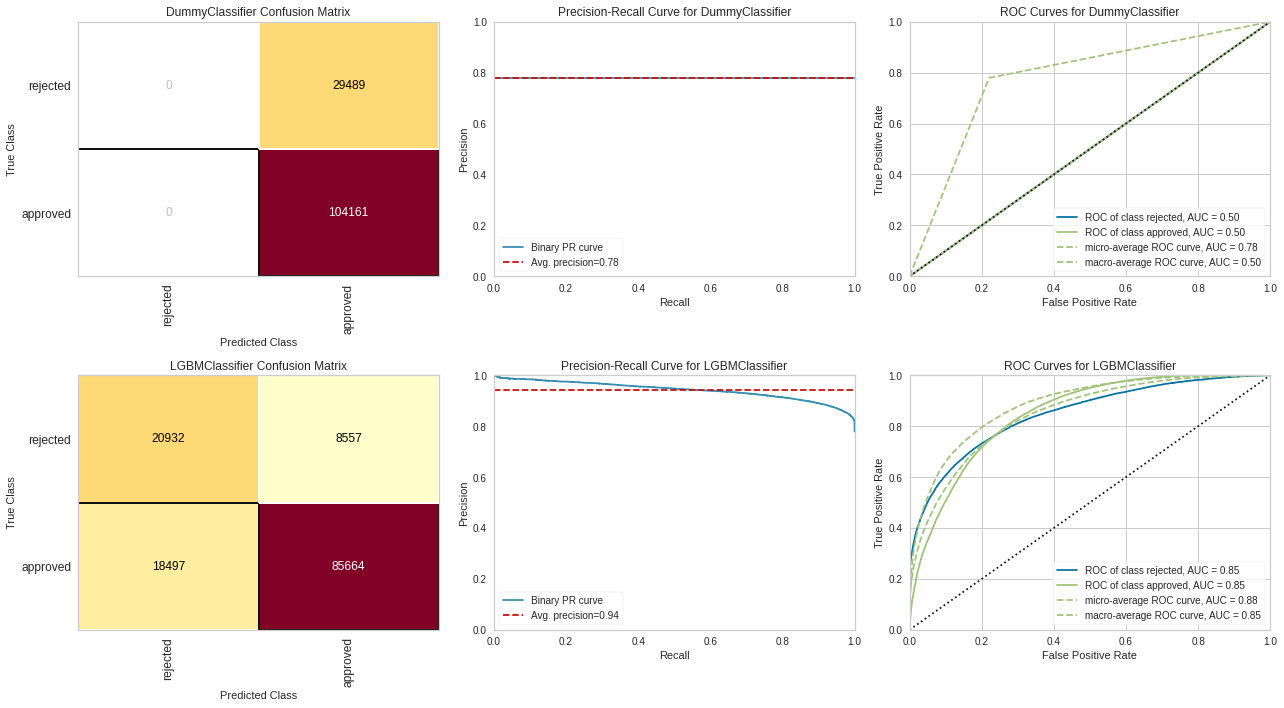

In [ ]:
plot_cm_pr_roc_curves_yb(
    models=fitted_models,
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test,
    plot_size=(18, 10),
    class_labels=['rejected','approved'],
    plot_threshold=False
)

So we can see that the model false negatives, but that could be a problem for a client not the bank in most cases. Also, the data could be biased towards people who get approved, because this application history data is of clients that already have been approved.

In [ ]:
_ = joblib.dump(lgbm_clf, "application_clf_lgbm.pkl")

In [ ]:
explainer = shap.TreeExplainer(lgbm_clf)

shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


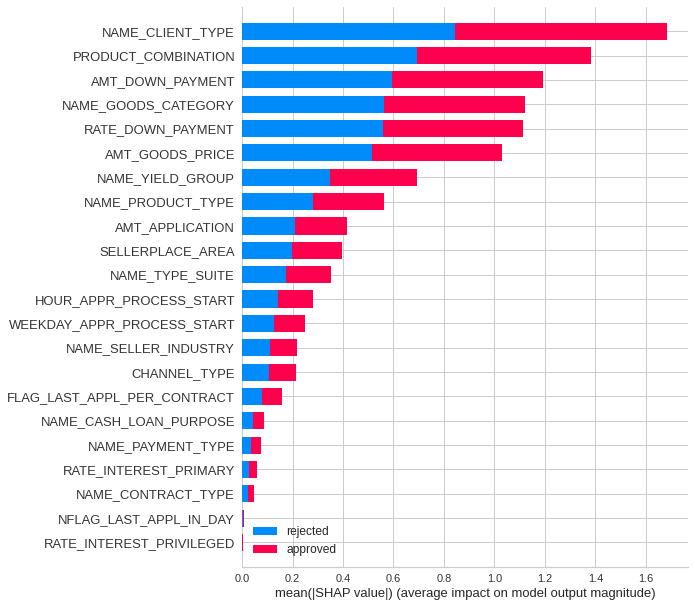

In [ ]:
shap.summary_plot(shap_values, X_test, class_names=['rejected','approved'], 
                  max_display=22)

The most important variable is NAME_CLIENT_TYPE which means whether or not a client is old or new which is specific to homecredit clients. Other variables like PRODUCT_COMBINATION, AMT_DOWN_PAYMENT, NAME_GOODS_CATEGORY are also important which makes sense, because they describe how much money is being asked for and what will they do with it.

## Streamlit web application

Link: https://streamlitapp-t3oyhqidxq-uc.a.run.app

## Project summary

EDA:
- There is a statisticly significant difference in terms of default risk for females and males. The risk is higher for males;
- There is a statisticly significant difference in terms of default risk for people who have children and not. The risk is higher for people that have children;
- There is no statisticly significant difference in terms of default risk for income;
- There is a statisticly significant difference in terms of default risk for credit amount. The risk is higher for lower credit amount;

Default risk prediction:
- ROC AUC on test set - 0.794;
- False positves could be reduced by increasing the threshold for the probability of default.

Cluster analysis:
- 6 high dimensional clusters were detected;
- Clustering model could be used for recommending services to clients specific to some cluster;

Application outcome prediction:
- ROC AUC on the test set - 0.848;
- Due to the data having approved clients bias this model might not perform well on new clients who did not have any approved applications in the past;

**Suggestions for improvements**

- The decision threshold of models can be tweaked for recall or precision according to business requirements;
- Try to use databricks or dataproc in the future;